In [1]:
# import all packages and dependencies

import os
import cv2
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.utils import image_dataset_from_directory
from tensorflow.keras import Sequential, layers, models, optimizers, callbacks
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.applications import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input as preprocess_input_vgg16
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.applications.densenet import preprocess_input as preprocess_input_densenet
from tensorflow.keras.applications import EfficientNetB7
from tensorflow.keras.applications.efficientnet import preprocess_input as preprocess_input_efficientnet

2024-02-08 12:11:28.366075: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-08 12:11:28.366176: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-08 12:11:28.532342: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
# set parameters

fpath = "/kaggle/input/stanford-dogs-dataset-traintest/cropped/train"
categories = os.listdir(fpath)
num_classes = len(categories)
seed=1234
validation_split=0.2
batch_size=32
labels="inferred"
label_mode="categorical"
input_shape=(256, 256, 3)
#learning_rate=1e-4
#epochs=100

In [3]:
# import training and test data

# train data
train_data_path = "/kaggle/input/stanford-dogs-dataset-traintest/cropped/train"
images_train = image_dataset_from_directory(
    train_data_path,
    seed=seed,
    subset="both",
    validation_split=validation_split,
    batch_size=batch_size,
    labels=labels,
    label_mode=label_mode
)


# test data
test_data_path = "/kaggle/input/stanford-dogs-dataset-traintest/cropped/test"
images_test = image_dataset_from_directory(
    test_data_path,
    seed=seed,
    subset=None,
    validation_split=None,
    batch_size=batch_size,
    labels=labels,
    label_mode=label_mode
)

Found 12000 files belonging to 120 classes.
Using 9600 files for training.
Using 2400 files for validation.
Found 8580 files belonging to 120 classes.


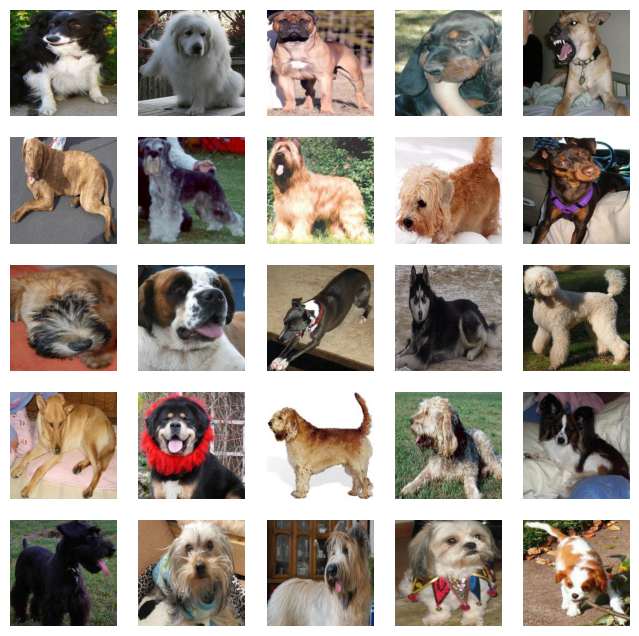

In [4]:
# see what you got in your training directory

fig, axes = plt.subplots(nrows=5, ncols=5, figsize=(8,8))

# Iterate through the subplots and display random dog images
for indx, axis in enumerate(axes.flatten()):
    train_data_path_TEMP = random.choice(os.listdir(train_data_path))
    # Get a random index within the range of available images
    rnd_indx = np.random.randint(0, len(os.listdir(train_data_path+'/'+train_data_path_TEMP)))

    # Load and display the image using Matplotlib
    images = os.listdir(train_data_path+'/'+train_data_path_TEMP+'/')
    img = plt.imread(train_data_path+'/'+train_data_path_TEMP + '/'+images[rnd_indx])

    imgplot = axis.imshow(img)
    axis.set_axis_off()  # Turn off the axis for better visualization

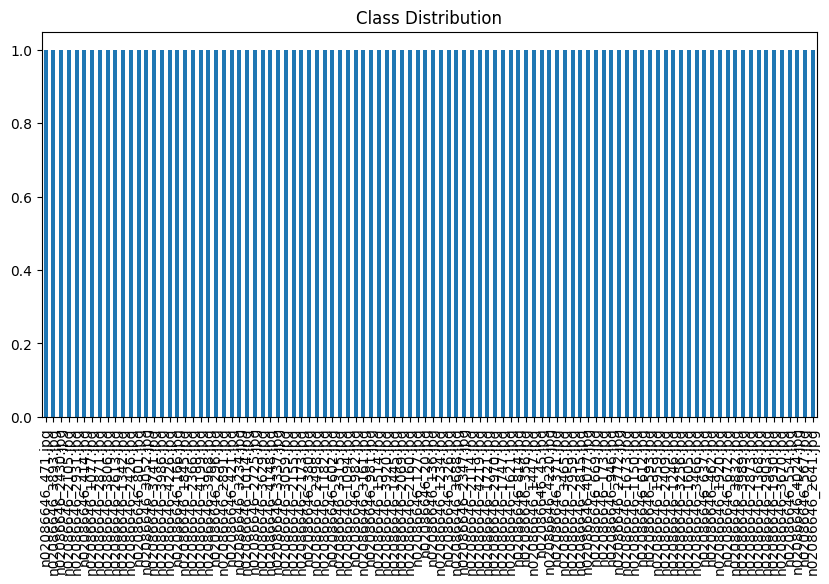

In [5]:
# Display distribution of classes

label_counts = pd.Series(images).value_counts()
label_counts.plot(kind='bar', figsize=(10,5), title="Class Distribution")
plt.show()

# Now, let's compare two models for baseline #

## 1) VGG16 model

In [6]:
# Preprocess training and validation data for VGG16 model

images_train_VGG16_preproc = images_train[0].map(
  lambda x, y: (preprocess_input_vgg16(x), y))
images_val_VGG16_preproc = images_train[1].map(
  lambda x, y: (preprocess_input_vgg16(x), y))

In [7]:
##############
# load model #
##############
def load_pretrained_model(input_shape=input_shape):
    """
    Load pre-trained VGG16 model and freeze pre-trained layers
    """
    vgg16_model = VGG16(weights="imagenet",
                        include_top=False,
                        input_shape=input_shape)
    vgg16_model.trainable = False
    return vgg16_model

###############
# build model #
###############
def build_model(base_model):
    """
    Build model
    """
    model = models.Sequential() # Instantiate the Sequential model
    model.add(base_model)
    model.add(layers.Flatten()) # Flattening layer
    model.add(layers.Dense(500, activation='relu')) # Hidden Dense layer
    model.add(layers.Dense(120, activation='softmax')) # Predictive layer, here 120 can be replaced with the num_classes parameter written above
    return model

#################
# compile model #
#################
def compile_model(model):
    """
    Compile model now
    """
    model.compile(loss='categorical_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])
    return model

###############
# train model #
###############
def train_model(model, train_data, val_data):
    """
    Train the model
    """
    es = callbacks.EarlyStopping(patience=3)
    history = model.fit(train_data,
                        epochs=100,
                        batch_size=batch_size,
                        callbacks=[es],
                        validation_data=val_data,
                        verbose=1)
    return history

In [8]:
vgg16_base_model = load_pretrained_model(input_shape)
custom_model = build_model(vgg16_base_model)
compiled_model = compile_model(custom_model)
history_vgg16 = train_model(compiled_model, images_train_VGG16_preproc, images_val_VGG16_preproc)

58889256/58889256 [==============================] - 1s 0us/step
Epoch 1/100


I0000 00:00:1707394322.509027      90 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


300/300 [==============================] - 71s 194ms/step - loss: 8.9063 - accuracy: 0.0518 - val_loss: 4.5392 - val_accuracy: 0.0654
Epoch 2/100
300/300 [==============================] - 65s 216ms/step - loss: 4.0253 - accuracy: 0.1412 - val_loss: 4.0233 - val_accuracy: 0.1221
Epoch 3/100
300/300 [==============================] - 66s 217ms/step - loss: 3.5760 - accuracy: 0.1959 - val_loss: 4.0796 - val_accuracy: 0.1338
Epoch 4/100
300/300 [==============================] - 66s 219ms/step - loss: 3.1882 - accuracy: 0.2571 - val_loss: 4.0215 - val_accuracy: 0.1875
Epoch 5/100
300/300 [==============================] - 66s 218ms/step - loss: 2.9323 - accuracy: 0.3019 - val_loss: 3.6214 - val_accuracy: 0.1996
Epoch 6/100
300/300 [==============================] - 66s 219ms/step - loss: 2.5938 - accuracy: 0.3605 - val_loss: 3.4980 - val_accuracy: 0.2317
Epoch 7/100
300/300 [==============================] - 66s 219ms/step - loss: 2.4299 - accuracy: 0.3839 - val_loss: 3.5818 - val_accurac

In [9]:
# Evaluate VGG16 model on validation set
vgg16_val_loss, vgg16_val_accuracy = compiled_model.evaluate(images_val_VGG16_preproc)
vgg16_val_accuracy

75/75 [==============================] - 13s 172ms/step - loss: 3.7982 - accuracy: 0.3113


0.3112500011920929

In [10]:
# Now evaluate VGG16 model on Test data

# Preprocess test data for VGG16 model

images_test_VGG16_preproc = images_test.map(
  lambda x, y: (preprocess_input_vgg16(x), y))

def evaluate_model(model, test_data):
    """
    Evaluate on test data
    """
    loss, accuracy_vgg16 = model.evaluate(test_data)
    print(f"Test Loss: {loss}")
    print(f"Test Accuracy: {accuracy_vgg16}")

    return accuracy_vgg16

vgg16_test_accuracy = evaluate_model(compiled_model, images_test_VGG16_preproc)

269/269 [==============================] - 49s 179ms/step - loss: 3.5099 - accuracy: 0.3323
Test Loss: 3.5099294185638428
Test Accuracy: 0.3322843909263611


## 2) Densenet121 model

In [11]:
# Preprocess training and validation data for DenseNet121 model

images_train_dense_preproc = images_train[0].map(
  lambda x, y: (preprocess_input_densenet(x), y))
images_val_dense_preproc = images_train[1].map(
  lambda x, y: (preprocess_input_densenet(x), y))

In [12]:
# Load pre-trained DenseNet121 model with specified input shape

def load_pretrained_model(input_shape=input_shape):
    dense121_model = DenseNet121(weights="imagenet",
                                 include_top=False,
                                 input_shape=input_shape)
    dense121_model.trainable = False
    return dense121_model


In [13]:
# use training data

dense121_base_model = load_pretrained_model(input_shape)
custom_model = build_model(dense121_base_model)
compiled_model = compile_model(custom_model)
history_dense121 = train_model(compiled_model, images_train_dense_preproc, images_val_dense_preproc)

29084464/29084464 [==============================] - 0s 0us/step
Epoch 1/100
300/300 [==============================] - 59s 157ms/step - loss: 3.7222 - accuracy: 0.3610 - val_loss: 1.4562 - val_accuracy: 0.5867
Epoch 2/100
300/300 [==============================] - 45s 148ms/step - loss: 0.7551 - accuracy: 0.7734 - val_loss: 1.2907 - val_accuracy: 0.6587
Epoch 3/100
300/300 [==============================] - 45s 150ms/step - loss: 0.2981 - accuracy: 0.8997 - val_loss: 1.5121 - val_accuracy: 0.6604
Epoch 4/100
300/300 [==============================] - 45s 149ms/step - loss: 0.1583 - accuracy: 0.9484 - val_loss: 1.5501 - val_accuracy: 0.6446
Epoch 5/100
300/300 [==============================] - 45s 148ms/step - loss: 0.1093 - accuracy: 0.9643 - val_loss: 1.5545 - val_accuracy: 0.6596


In [14]:
# Evaluate DenseNet121 model on validation set
densenet121_val_loss, densenet121_val_accuracy = compiled_model.evaluate(images_val_dense_preproc)
densenet121_val_accuracy

75/75 [==============================] - 9s 114ms/step - loss: 1.5545 - accuracy: 0.6596


0.659583330154419

In [15]:
# Now evaluate Densenet121 model on Test data

# Preprocess test data for DenseNet121 model

images_test_dense_preproc = images_test.map(
  lambda x, y: (preprocess_input_densenet(x), y))

def evaluate_model(model, test_data):
    """
    Evaluate on test data
    """
    loss, accuracy_densenet = model.evaluate(test_data)
    print(f"Test Loss: {loss}")
    print(f"Test Accuracy: {accuracy_densenet}")

    return accuracy_densenet

densenet_test_accuracy = evaluate_model(compiled_model, images_test_dense_preproc)

269/269 [==============================] - 34s 124ms/step - loss: 1.4801 - accuracy: 0.6914
Test Loss: 1.4800528287887573
Test Accuracy: 0.6913753151893616


## 3) EfficientNetB7 model

In [16]:
# Preprocess training and validation data for EfficientNetB7

images_train_efficient_preproc = images_train[0].map(
  lambda x, y: (preprocess_input_efficientnet(x), y))
images_val_efficient_preproc = images_train[1].map(
  lambda x, y: (preprocess_input_efficientnet(x), y))

In [17]:
# Load pre-trained EfficientNetB7 model with specified input shape
def load_pretrained_model(input_shape=input_shape):
    efficientnetb7_model = EfficientNetB7(weights="imagenet",
                                          include_top=False,
                                          input_shape=input_shape)
    efficientnetb7_model.trainable = False
    return efficientnetb7_model

In [18]:
efficientnetb7_base_model = load_pretrained_model(input_shape)
custom_model = build_model(efficientnetb7_base_model)
compiled_model = compile_model(custom_model)
history_efficientnetb7 = train_model(compiled_model, images_train_efficient_preproc, images_val_efficient_preproc)

258076736/258076736 [==============================] - 1s 0us/step
Epoch 1/100


2024-02-08 12:30:20.605515: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_2/efficientnetb7/block1b_drop/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


300/300 [==============================] - 209s 617ms/step - loss: 3.2786 - accuracy: 0.6252 - val_loss: 1.0931 - val_accuracy: 0.7763
Epoch 2/100
300/300 [==============================] - 176s 587ms/step - loss: 0.7313 - accuracy: 0.8558 - val_loss: 1.0281 - val_accuracy: 0.8100
Epoch 3/100
300/300 [==============================] - 176s 588ms/step - loss: 0.4229 - accuracy: 0.8988 - val_loss: 0.9718 - val_accuracy: 0.8292
Epoch 4/100
300/300 [==============================] - 176s 587ms/step - loss: 0.4868 - accuracy: 0.9169 - val_loss: 1.1618 - val_accuracy: 0.8288
Epoch 5/100
300/300 [==============================] - 176s 588ms/step - loss: 0.4499 - accuracy: 0.9211 - val_loss: 1.3275 - val_accuracy: 0.8296
Epoch 6/100
300/300 [==============================] - 176s 587ms/step - loss: 0.6057 - accuracy: 0.9190 - val_loss: 1.3177 - val_accuracy: 0.8421


In [19]:
# Evaluate EfficientNetB7 model on validation set
efficientnetb7_val_loss, efficientnetb7_val_accuracy = compiled_model.evaluate(images_val_efficient_preproc)
efficientnetb7_val_accuracy

75/75 [==============================] - 33s 435ms/step - loss: 1.3177 - accuracy: 0.8421


0.8420833349227905

In [20]:
# Now evaluate EfficientNetB7 model on Test data

# Preprocess test data for EfficientNetB7

images_test_efficient_preproc = images_test.map(
  lambda x, y: (preprocess_input_efficientnet(x), y))

def evaluate_model(model, test_data):
    """
    Evaluate on test data
    """
    loss, accuracy_efficientnet = model.evaluate(test_data)
    print(f"Test Loss: {loss}")
    print(f"Test Accuracy: {accuracy_efficientnet}")

    return accuracy_efficientnet

efficient_test_accuracy = evaluate_model(compiled_model, images_test)

269/269 [==============================] - 119s 439ms/step - loss: 1.1737 - accuracy: 0.8569
Test Loss: 1.1737185716629028
Test Accuracy: 0.8568764328956604


# Visualize the results and see which pre-trained model is working better

In [21]:
def plot_loss_accuracy(history):

    with plt.style.context('seaborn-deep'):

        fig, ax = plt.subplots(1, 2, figsize=(15, 4))

        ## Plot Losses and Accuracies
        x_axis = np.arange(len(history.history['loss']))

        ax[0].set_title("Loss")
        ax[0].plot(x_axis, history.history['loss'], color="blue", linestyle=":", marker="X", label="Train Loss")
        ax[0].plot(x_axis, history.history['val_loss'], color="orange", linestyle="-", marker="X", label="Val Loss")

        ax[1].set_title("Accuracy")
        ax[1].plot(x_axis, history.history['accuracy'], color="blue", linestyle=":", marker="X", label="Train Accuracy")
        ax[1].plot(x_axis,
                   history.history['val_accuracy'],
                   color="orange",
                   linestyle="-",
                   marker="X",
                   label="Val Accuracy")

        ## Customization
        ax[0].grid(axis="x", linewidth=0.5)
        ax[0].grid(axis="y", linewidth=0.5)
        ax[0].legend()

        ax[1].grid(axis="x", linewidth=0.5)
        ax[1].grid(axis="y", linewidth=0.5)
        ax[1].legend()


        plt.show()

### Plot loss and accuracy

Graphs for VGG16 pre-trained model


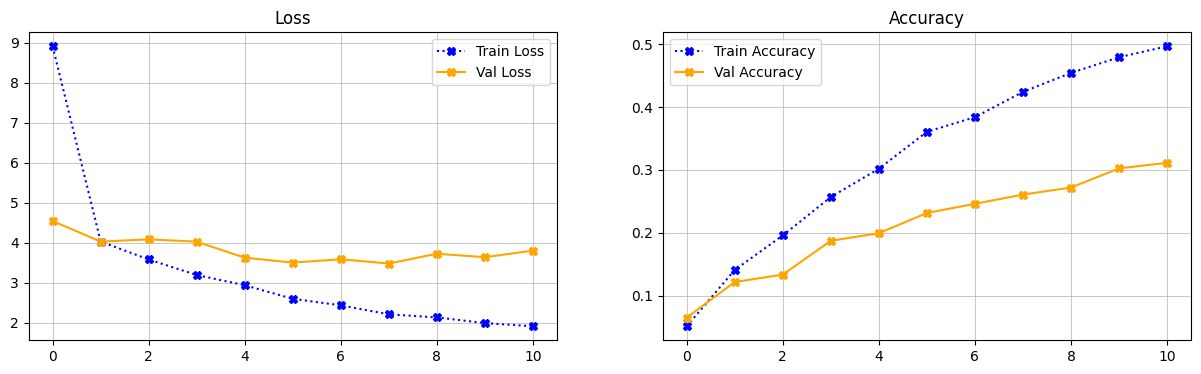

Graphs for DenseNet121 pre-trained model


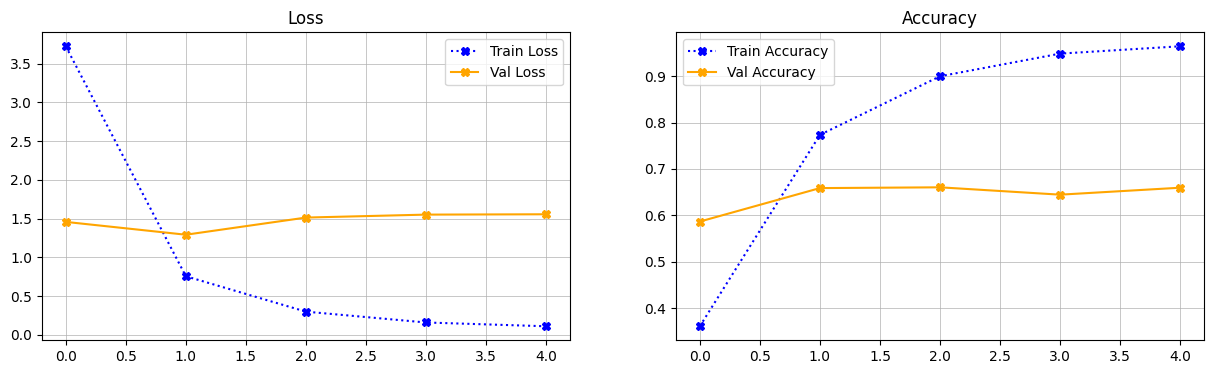

Graphs for EfficientNetB7 pre-trained model


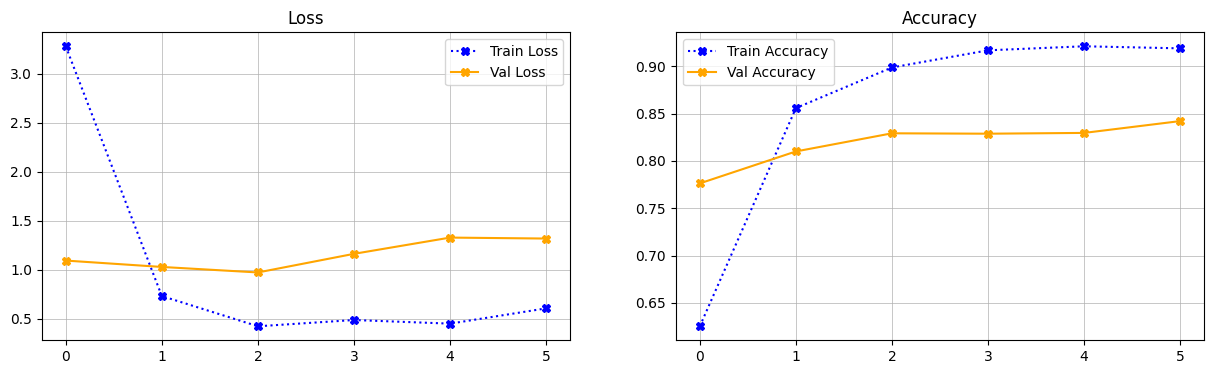

In [22]:
print("Graphs for VGG16 pre-trained model")
plot_loss_accuracy(history_vgg16)

print("Graphs for DenseNet121 pre-trained model")
plot_loss_accuracy(history_dense121)

print("Graphs for EfficientNetB7 pre-trained model")
plot_loss_accuracy(history_efficientnetb7)

### Plot validation accuracy comparison

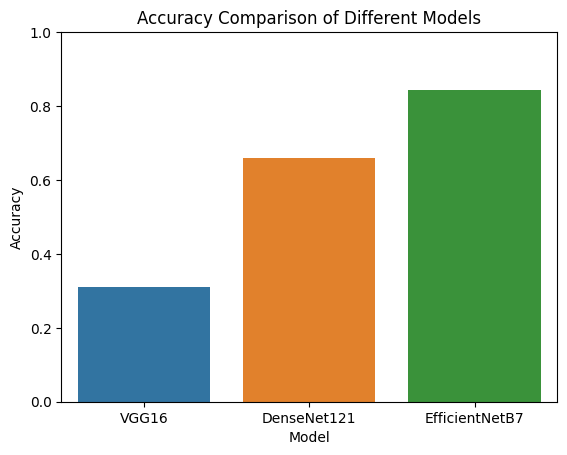

In [23]:
# Bring all accuracies together
acc_vgg16 = vgg16_val_accuracy
acc_densenet121 = densenet121_val_accuracy
acc_efficientnetb7 = efficientnetb7_val_accuracy

# Create a DataFrame to store the accuracy data
data = pd.DataFrame({
    'Model': ['VGG16', 'DenseNet121', 'EfficientNetB7'],
    'Accuracy': [acc_vgg16, acc_densenet121, acc_efficientnetb7]
})

# Plot the accuracies using Seaborn
sns.barplot(x='Model', y='Accuracy', data=data)
plt.title('Validation Accuracy Comparison of Different Models')
plt.xlabel('Model')
plt.ylabel('Accuracy')
plt.ylim(0, 1)  # Set y-axis limit to 0-1 (assuming accuracy is in the range 0-1)
plt.show()

### Plot test accuracy for comparison

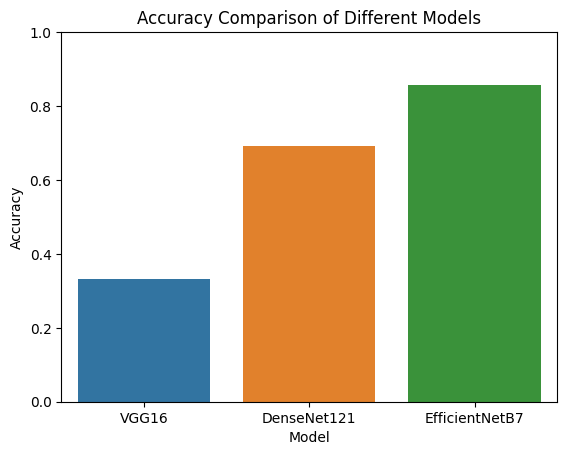

In [24]:
# Bring all accuracies together
acc_vgg16 = vgg16_test_accuracy
acc_densenet121 = densenet_test_accuracy
acc_efficientnetb7 = efficient_test_accuracy

# Create a DataFrame to store the accuracy data
data = pd.DataFrame({
    'Model': ['VGG16', 'DenseNet121', 'EfficientNetB7'],
    'Accuracy': [acc_vgg16, acc_densenet121, acc_efficientnetb7]
})

# Plot the accuracies using Seaborn
sns.barplot(x='Model', y='Accuracy', data=data)
plt.title('Test Accuracy Comparison of Different Models')
plt.xlabel('Model')
plt.ylabel('Accuracy')
plt.ylim(0, 1)  # Set y-axis limit to 0-1 (assuming accuracy is in the range 0-1)
plt.show()
